In [ ]:
# Import necessary libraries
import glob
from pathlib import Path
import warnings

import lpips
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.color import lab2rgb, rgb2lab
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

import torch
import torchvision.models as models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from colormath.color_objects import LabColor, sRGBColor

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*negative Z values.*')

In [2]:
# Device configuration
def get_device():
    if torch.cuda.is_available():
        dev = torch.device("cuda")
        name = torch.cuda.get_device_name(0)
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        dev = torch.device("mps")
        name = "Apple Silicon"
    else:
        dev = torch.device("cpu")
        name = "CPU"
    return dev, name

device, device_name = get_device()
print(f"Using device: {device_name} ({device})")

Using device: NVIDIA GeForce RTX 5060 Ti (cuda)


In [3]:
# Configuration
MODEL_ID = 'B'
BATCH_SIZE = 64
IMG_SIZE = 256
EPOCHS = 50
SAVE_INTERVAL = 10

# Model-specific configuration
USE_GAN = False
USE_L1 = True
USE_PERCEPTUAL = True
LAMBDA_L1 = 100.0
LAMBDA_PERCEPTUAL = 10.0

print(f"Model {MODEL_ID} Configuration:")
print(f"  GAN: {USE_GAN}")
print(f"  L1 Loss: {USE_L1} (λ₁ = {LAMBDA_L1})")
print(f"  Perceptual Loss: {USE_PERCEPTUAL} (λ₂ = {LAMBDA_PERCEPTUAL})")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")

Model B Configuration:
  GAN: False
  L1 Loss: True (λ₁ = 100.0)
  Perceptual Loss: True (λ₂ = 10.0)
  Epochs: 50
  Batch Size: 64


In [4]:
# Dataset class
class ColorizeDataset(Dataset):
    def __init__(self, root_dir, img_size=256, split='train'):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.split = split
        
        color_dir = self.root_dir / f"{split}_color"
        self.color_paths = sorted(glob.glob(str(color_dir / "*.jpg")))
        
        black_dir = self.root_dir / f"{split}_black"
        self.black_paths = sorted(glob.glob(str(black_dir / "*.jpg")))
        
        assert len(self.color_paths) == len(self.black_paths)
        
        # Data augmentation for training set
        if split == 'train':
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ToTensor()
            ])
        else:
            # No augmentation for validation and test sets
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor()
            ])
        
        print(f"Loaded {len(self.color_paths)} {split} image pairs")
    
    def __len__(self):
        return len(self.color_paths)
    
    def __getitem__(self, idx):
        color_img = Image.open(self.color_paths[idx]).convert('RGB')
        color_img = self.transform(color_img)
        
        gray_img = Image.open(self.black_paths[idx]).convert('L')
        gray_img = self.transform(gray_img)
        
        color_img_np = (color_img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        lab_img = rgb2lab(color_img_np)
        
        L = lab_img[:, :, 0] / 50.0 - 1.0
        ab = lab_img[:, :, 1:] / 128.0
        
        L = torch.from_numpy(L).unsqueeze(0).float()
        ab = torch.from_numpy(ab).permute(2, 0, 1).float()
        
        return L, ab, gray_img

# Load datasets
train_dataset = ColorizeDataset('../data/colorize_dataset/data', img_size=IMG_SIZE, split='train')
val_dataset = ColorizeDataset('../data/colorize_dataset/data', img_size=IMG_SIZE, split='val')
test_dataset = ColorizeDataset('../data/colorize_dataset/data', img_size=IMG_SIZE, split='test')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

# Display dataset statistics
print(f"\n{'='*60}")
print(f"Dataset Statistics:")
print(f"{'='*60}")
print(f"Training set:   {len(train_dataset):4d} images ({len(train_loader):3d} batches)")
print(f"Validation set: {len(val_dataset):4d} images ({len(val_loader):3d} batches)")
print(f"Test set:       {len(test_dataset):4d} images ({len(test_loader):3d} batches)")
print(f"Image size:     {IMG_SIZE}×{IMG_SIZE} pixels")
print(f"Batch size:     {BATCH_SIZE}")
print(f"{'='*60}\n")

Loaded 4750 train image pairs
Loaded 250 val image pairs
Loaded 739 test image pairs

Dataset Statistics:
Training set:   4750 images ( 75 batches)
Validation set:  250 images (  4 batches)
Test set:        739 images ( 12 batches)
Image size:     256×256 pixels
Batch size:     64



## U-Net Generator Architecture

In [5]:
# U-Net components
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()
        
        self.down1 = nn.Conv2d(in_channels, 64, 4, 2, 1)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True)
        self.down5 = UNetBlock(512, 512, down=True)
        self.down6 = UNetBlock(512, 512, down=True)
        self.down7 = UNetBlock(512, 512, down=True)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up4 = UNetBlock(1024, 512, down=False)
        self.up5 = UNetBlock(1024, 256, down=False)
        self.up6 = UNetBlock(512, 128, down=False)
        self.up7 = UNetBlock(256, 64, down=False)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        bottleneck = self.bottleneck(d7)
        
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], dim=1))
        u3 = self.up3(torch.cat([u2, d6], dim=1))
        u4 = self.up4(torch.cat([u3, d5], dim=1))
        u5 = self.up5(torch.cat([u4, d4], dim=1))
        u6 = self.up6(torch.cat([u5, d3], dim=1))
        u7 = self.up7(torch.cat([u6, d2], dim=1))
        
        output = self.final(torch.cat([u7, d1], dim=1))
        return output

# Initialize generator
generator = UNetGenerator(in_channels=1, out_channels=2).to(device)
print("U-Net Generator initialized")

U-Net Generator initialized


## Perceptual Loss

In [6]:
# Perceptual Loss using VGG16
class PerceptualLoss(nn.Module):
    """Perceptual loss using VGG16 features"""
    def __init__(self):
        super().__init__()
        try:
            from torchvision.models import VGG16_Weights
            vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features
        except ImportError:
            vgg = models.vgg16(pretrained=True).features
        
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:16]).eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.criterion = nn.L1Loss()
    
    def forward(self, generated, target):
        gen_rgb = torch.cat([generated, generated[:, :1, :, :]], dim=1)
        target_rgb = torch.cat([target, target[:, :1, :, :]], dim=1)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(generated.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(generated.device)
        
        gen_normalized = (gen_rgb - mean) / std
        target_normalized = (target_rgb - mean) / std
        
        gen_features = self.feature_extractor(gen_normalized)
        target_features = self.feature_extractor(target_normalized)
        
        return self.criterion(gen_features, target_features)

perceptual_loss = PerceptualLoss().to(device)
print("Perceptual loss initialized")

Perceptual loss initialized


## Training Setup

In [7]:
# Validation function
def validate_epoch(generator, val_loader, device):
    generator.eval()
    epoch_loss = 0.0
    
    with torch.no_grad():
        for L, ab_real, _ in tqdm(val_loader, desc="Validating", leave=False):
            L = L.to(device)
            ab_real = ab_real.to(device)
            
            ab_fake = generator(L)
            
            # Calculate loss: L1 + Perceptual (same as training but no gradient)
            loss = l1_loss(ab_fake, ab_real) * LAMBDA_L1 + perceptual_loss(ab_fake, ab_real) * LAMBDA_PERCEPTUAL
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(val_loader)

# Visualization function for validation samples
def visualize_validation_samples(generator, val_loader, device, epoch, save_dir, num_samples=5):
    generator.eval()
    
    with torch.no_grad():
        L, ab_real, gray_img = next(iter(val_loader))
        L = L[:num_samples].to(device)
        ab_real = ab_real[:num_samples]
        gray_img = gray_img[:num_samples]
        
        ab_fake = generator(L).cpu()
        L = L.cpu()
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        
        for i in range(num_samples):
            # Grayscale input
            axes[i, 0].imshow(gray_img[i].squeeze(), cmap='gray')
            axes[i, 0].set_title('Input (Grayscale)', fontweight='bold')
            axes[i, 0].axis('off')
            
            # Generated colorization
            L_np = ((L[i].squeeze().numpy() + 1.0) * 50.0)
            ab_fake_np = ab_fake[i].permute(1, 2, 0).numpy() * 128.0
            lab_fake = np.zeros((IMG_SIZE, IMG_SIZE, 3))
            lab_fake[:, :, 0] = L_np
            lab_fake[:, :, 1:] = ab_fake_np
            rgb_fake = lab2rgb(lab_fake)
            
            axes[i, 1].imshow(rgb_fake)
            axes[i, 1].set_title('Generated Color', fontweight='bold')
            axes[i, 1].axis('off')
            
            # Ground truth
            ab_real_np = ab_real[i].permute(1, 2, 0).numpy() * 128.0
            lab_real = np.zeros((IMG_SIZE, IMG_SIZE, 3))
            lab_real[:, :, 0] = L_np
            lab_real[:, :, 1:] = ab_real_np
            rgb_real = lab2rgb(lab_real)
            
            axes[i, 2].imshow(rgb_real)
            axes[i, 2].set_title('Ground Truth', fontweight='bold')
            axes[i, 2].axis('off')
        
        plt.suptitle(f'Validation Samples - Epoch {epoch}', fontsize=16, fontweight='bold', y=1.0)
        plt.tight_layout()
        
        output_path = save_dir / f'val_samples_epoch_{epoch}.png'
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"  ✓ Validation samples saved to: {output_path.name}")
        
        # Display the plot in notebook
        plt.show()

In [8]:
# Loss functions and optimizer
l1_loss = nn.L1Loss()
optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training history
history = {
    'epoch': [],
    'train_loss': [], 
    'val_loss': [],
    'gen_loss': []
}

# Create save directories
save_dir = Path(f'../models/{MODEL_ID}')
results_dir = Path('../results')
save_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Model will be saved to: {save_dir}")
print(f"Results will be saved to: {results_dir}")

Model will be saved to: ..\models\B
Results will be saved to: ..\results


## Training Loop


Starting Training - Model B



Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1/50
  Train Loss: 29.6229
  Val Loss:   21.7589
  ✓ New best model saved! (Val Loss: 21.7589)
  ✓ New best model saved! (Val Loss: 21.7589)


Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2/50
  Train Loss: 19.8147
  Val Loss:   18.4284
  ✓ New best model saved! (Val Loss: 18.4284)
  ✓ New best model saved! (Val Loss: 18.4284)


Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3/50
  Train Loss: 17.8840
  Val Loss:   35.4771


Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4/50
  Train Loss: 17.3098
  Val Loss:   17.9007
  ✓ New best model saved! (Val Loss: 17.9007)
  ✓ New best model saved! (Val Loss: 17.9007)


Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5/50
  Train Loss: 16.3618
  Val Loss:   16.5349
  ✓ New best model saved! (Val Loss: 16.5349)
  ✓ New best model saved! (Val Loss: 16.5349)


Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 6/50
  Train Loss: 16.7380
  Val Loss:   16.0626
  ✓ New best model saved! (Val Loss: 16.0626)
  ✓ New best model saved! (Val Loss: 16.0626)


Epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 7/50
  Train Loss: 15.8324
  Val Loss:   17.0181


Epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 8/50
  Train Loss: 15.4923
  Val Loss:   16.1731


Epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 9/50
  Train Loss: 15.2600
  Val Loss:   15.2705
  ✓ New best model saved! (Val Loss: 15.2705)
  ✓ New best model saved! (Val Loss: 15.2705)


Epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 10/50
  Train Loss: 15.1352
  Val Loss:   16.3098
  ✓ Checkpoint saved at epoch 10
  ✓ Checkpoint saved at epoch 10
  ✓ Validation samples saved to: val_samples_epoch_10.png
  ✓ Validation samples saved to: val_samples_epoch_10.png


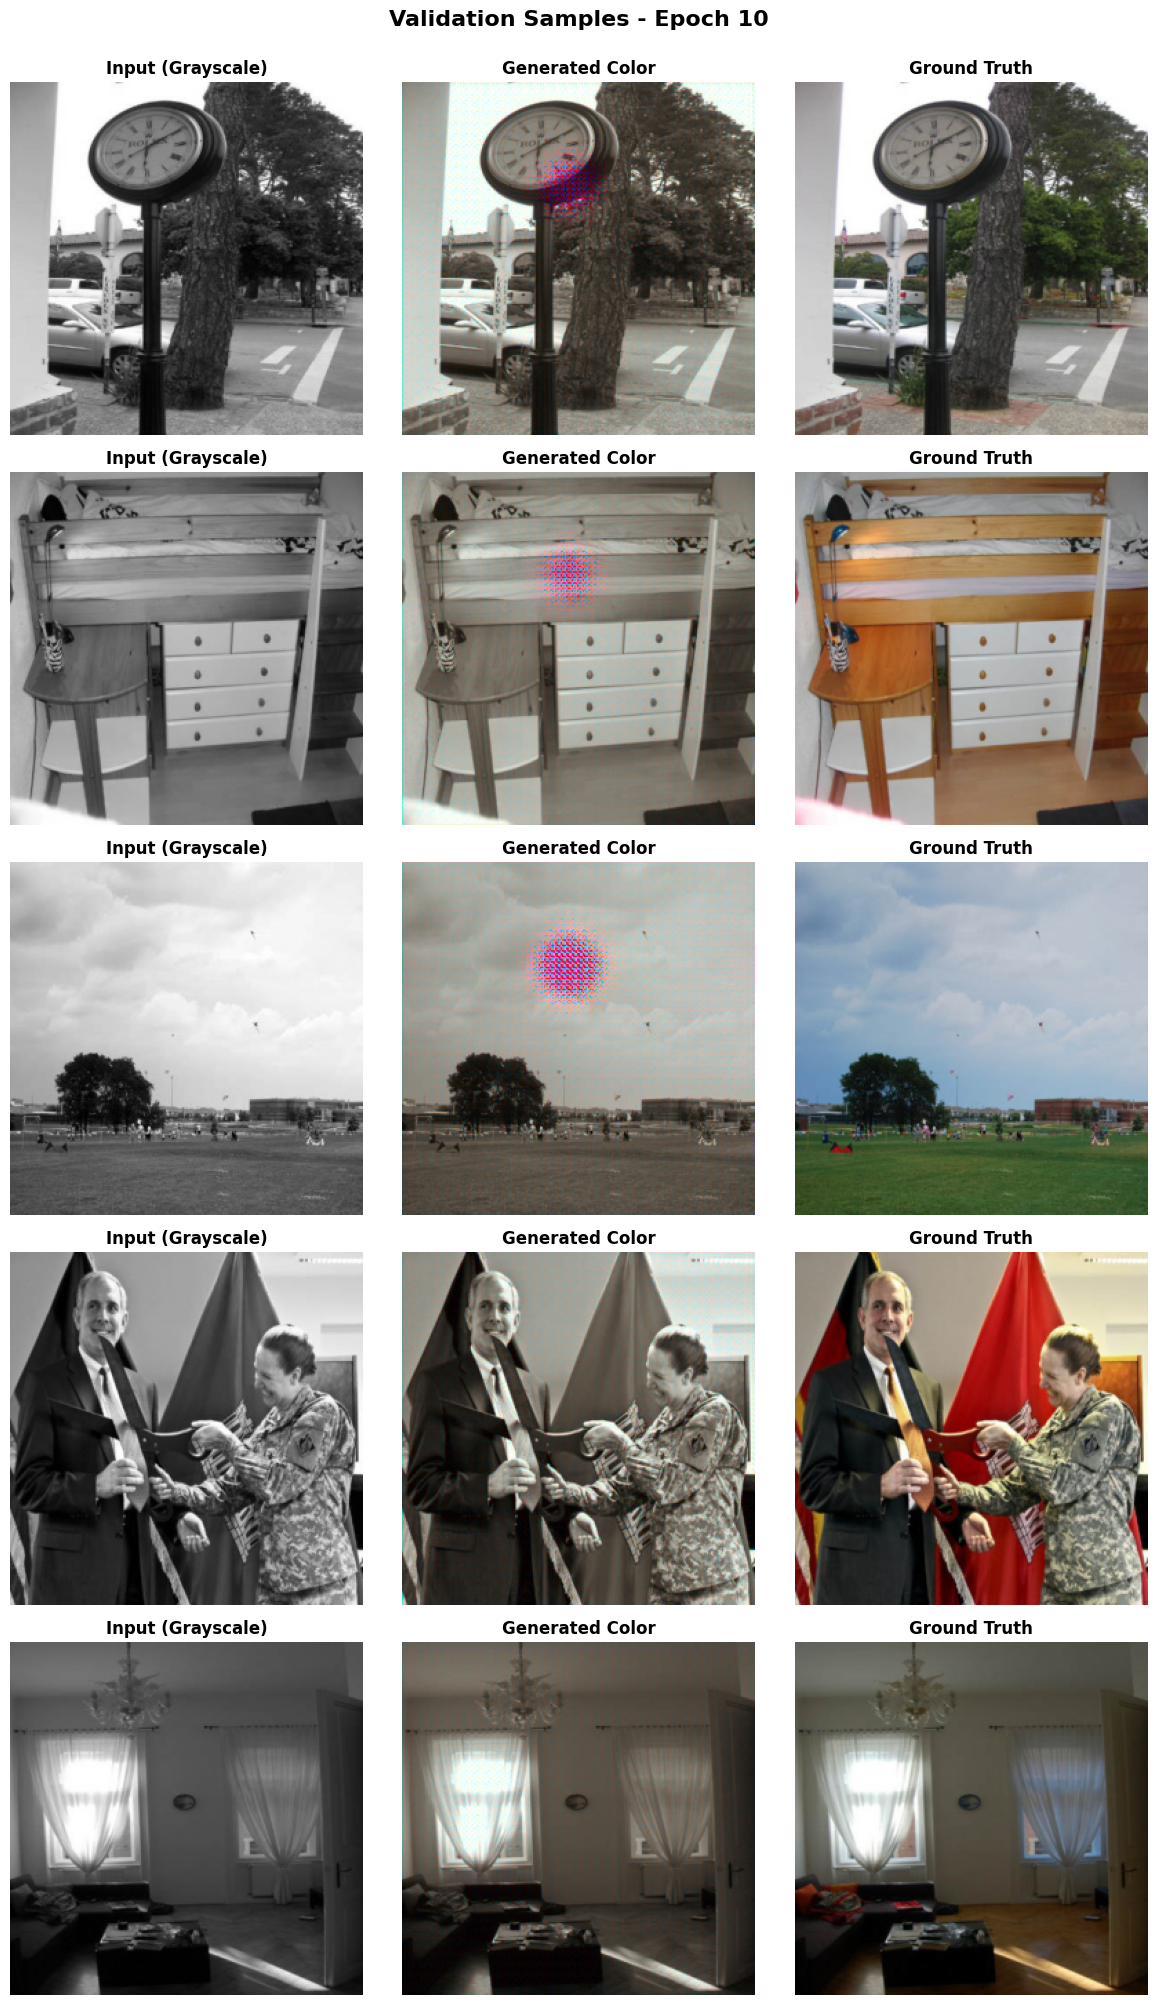

Epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 11/50
  Train Loss: 14.8315
  Val Loss:   14.7531
  ✓ New best model saved! (Val Loss: 14.7531)
  ✓ New best model saved! (Val Loss: 14.7531)


Epoch 12:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 12/50
  Train Loss: 14.8327
  Val Loss:   15.1047


Epoch 13:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 13/50
  Train Loss: 14.7333
  Val Loss:   14.5272
  ✓ New best model saved! (Val Loss: 14.5272)
  ✓ New best model saved! (Val Loss: 14.5272)


Epoch 14:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 14/50
  Train Loss: 14.5867
  Val Loss:   14.4302
  ✓ New best model saved! (Val Loss: 14.4302)
  ✓ New best model saved! (Val Loss: 14.4302)


Epoch 15:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 15/50
  Train Loss: 14.5976
  Val Loss:   14.3208
  ✓ New best model saved! (Val Loss: 14.3208)
  ✓ New best model saved! (Val Loss: 14.3208)


Epoch 16:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 16/50
  Train Loss: 14.4808
  Val Loss:   14.5716


Epoch 17:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 17/50
  Train Loss: 14.4019
  Val Loss:   17.0765


Epoch 18:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 18/50
  Train Loss: 14.5445
  Val Loss:   14.7484


Epoch 19:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 19/50
  Train Loss: 14.2515
  Val Loss:   15.1461


Epoch 20:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 20/50
  Train Loss: 14.1459
  Val Loss:   15.5676
  ✓ Checkpoint saved at epoch 20
  ✓ Checkpoint saved at epoch 20
  ✓ Validation samples saved to: val_samples_epoch_20.png
  ✓ Validation samples saved to: val_samples_epoch_20.png


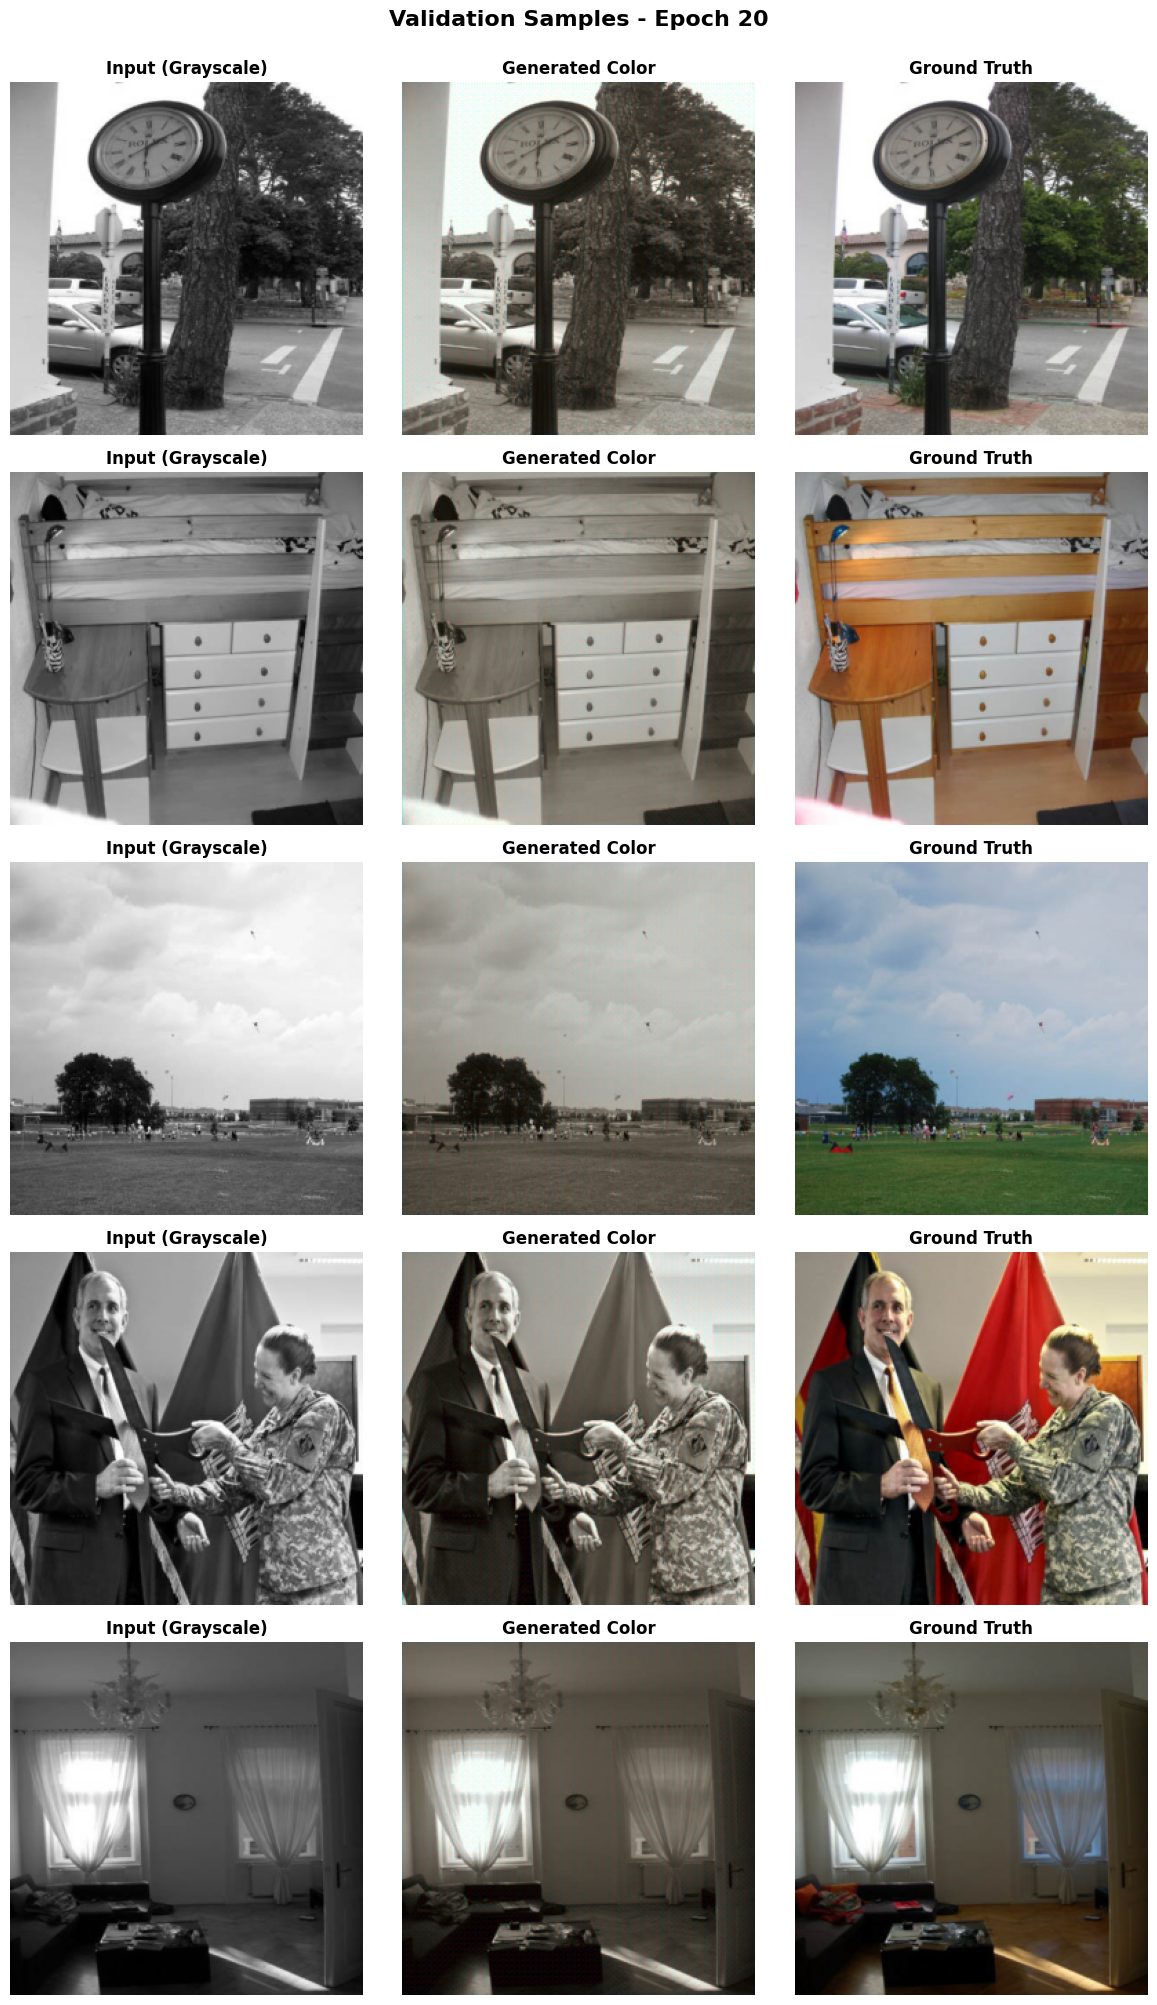

Epoch 21:   0%|          | 0/75 [00:00<?, ?it/s]

Validating:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 21/50
  Train Loss: 14.1814
  Val Loss:   14.1221
  ✓ New best model saved! (Val Loss: 14.1221)
  ✓ New best model saved! (Val Loss: 14.1221)


Epoch 22:   0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
# Training function
def train_epoch(generator, train_loader, optimizer, epoch, device):
    generator.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for L, ab_real, _ in pbar:
        L = L.to(device)
        ab_real = ab_real.to(device)
        
        optimizer.zero_grad()
        ab_fake = generator(L)
        
        # Combined loss: L1 + Perceptual
        loss_l1 = l1_loss(ab_fake, ab_real) * LAMBDA_L1
        loss_perceptual = perceptual_loss(ab_fake, ab_real) * LAMBDA_PERCEPTUAL
        loss = loss_l1 + loss_perceptual
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
    
    return epoch_loss / len(train_loader)

# Train model
best_val_loss = float('inf')

print(f"\n{'='*60}")
print(f"Starting Training - Model {MODEL_ID}")
print(f"{'='*60}\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    avg_train_loss = train_epoch(generator, train_loader, optimizer, epoch, device)
    
    # Validate
    avg_val_loss = validate_epoch(generator, val_loader, device)
    
    # Update history
    history['epoch'].append(epoch)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['gen_loss'].append(avg_train_loss)
    
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    
    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_val_loss': best_val_loss,
            'best_train_loss': avg_train_loss
        }
        torch.save(checkpoint, save_dir / 'best_model.pt')
        print(f"  ✓ New best model saved! (Val Loss: {best_val_loss:.4f})")
    
    # Save checkpoint at intervals
    if epoch % SAVE_INTERVAL == 0:
        checkpoint_path = save_dir / f"checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"  ✓ Checkpoint saved at epoch {epoch}")
        
        # Visualize validation samples every 10 epochs
        visualize_validation_samples(generator, val_loader, device, epoch, results_dir)
    
    # Save training history to CSV after each epoch
    history_df = pd.DataFrame(history)
    history_csv_path = results_dir / f'training_history_{MODEL_ID}.csv'
    history_df.to_csv(history_csv_path, index=False)
    
    # Clear cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Training history saved to: {history_csv_path}")
print(f"{'='*60}\n")

## Evaluation

In [ ]:
# Patch numpy for colormath compatibility
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item() if hasattr(x, 'item') else float(x)

# Evaluation metrics class
class ColorimetricEvaluator:
    def __init__(self, device):
        self.device = device
        self.lpips_model = lpips.LPIPS(net='alex').to(device)
        self.lpips_model.eval()
    
    def calculate_psnr(self, generated, target):
        gen_np = generated.cpu().numpy()
        target_np = target.cpu().numpy()
        psnr_values = []
        for i in range(gen_np.shape[0]):
            psnr = peak_signal_noise_ratio(target_np[i], gen_np[i], data_range=2.0)
            psnr_values.append(psnr)
        return np.mean(psnr_values)
    
    def calculate_ssim(self, generated, target):
        gen_np = generated.cpu().numpy()
        target_np = target.cpu().numpy()
        ssim_values = []
        for i in range(gen_np.shape[0]):
            gen_img = np.transpose(gen_np[i], (1, 2, 0))
            target_img = np.transpose(target_np[i], (1, 2, 0))
            ssim = structural_similarity(target_img, gen_img, data_range=2.0, channel_axis=2)
            ssim_values.append(ssim)
        return np.mean(ssim_values)
    
    def calculate_ciede2000(self, L, ab_generated, ab_target):
        L_np = ((L.cpu().numpy() + 1.0) * 50.0)
        ab_gen_np = ab_generated.cpu().numpy() * 128.0
        ab_target_np = ab_target.cpu().numpy() * 128.0
        
        delta_e_values = []
        for b in range(L_np.shape[0]):
            L_channel = L_np[b, 0]
            step = 8
            sample_indices = [(i, j) for i in range(0, L_channel.shape[0], step) for j in range(0, L_channel.shape[1], step)]
            
            pixel_deltas = []
            for i, j in sample_indices:
                lab_gen = LabColor(L_channel[i, j], ab_gen_np[b, 0, i, j], ab_gen_np[b, 1, i, j])
                lab_target = LabColor(L_channel[i, j], ab_target_np[b, 0, i, j], ab_target_np[b, 1, i, j])
                delta_e = delta_e_cie2000(lab_gen, lab_target)
                pixel_deltas.append(delta_e)
            
            delta_e_values.append(np.mean(pixel_deltas))
        return np.mean(delta_e_values)
    
    def calculate_lpips(self, L, ab_generated, ab_target):
        with torch.no_grad():
            batch_size = L.size(0)
            rgb_gen_list = []
            rgb_target_list = []
            
            for i in range(batch_size):
                L_np = ((L[i].cpu().squeeze().numpy() + 1.0) * 50.0)
                ab_gen_np = ab_generated[i].cpu().permute(1, 2, 0).numpy() * 128.0
                lab_gen = np.zeros((L_np.shape[0], L_np.shape[1], 3))
                lab_gen[:, :, 0] = L_np
                lab_gen[:, :, 1:] = ab_gen_np
                rgb_gen = lab2rgb(lab_gen)
                
                ab_target_np = ab_target[i].cpu().permute(1, 2, 0).numpy() * 128.0
                lab_target = np.zeros((L_np.shape[0], L_np.shape[1], 3))
                lab_target[:, :, 0] = L_np
                lab_target[:, :, 1:] = ab_target_np
                rgb_target = lab2rgb(lab_target)
                
                rgb_gen_list.append(rgb_gen)
                rgb_target_list.append(rgb_target)
            
            rgb_gen_tensor = torch.from_numpy(np.array(rgb_gen_list)).permute(0, 3, 1, 2).float() * 2 - 1
            rgb_target_tensor = torch.from_numpy(np.array(rgb_target_list)).permute(0, 3, 1, 2).float() * 2 - 1
            
            rgb_gen_tensor = rgb_gen_tensor.to(self.device)
            rgb_target_tensor = rgb_target_tensor.to(self.device)
            
            lpips_value = self.lpips_model(rgb_gen_tensor, rgb_target_tensor)
            return lpips_value.mean().item()
    
    def evaluate_batch(self, L, ab_generated, ab_target):
        metrics = {
            'PSNR': self.calculate_psnr(ab_generated, ab_target),
            'SSIM': self.calculate_ssim(ab_generated, ab_target),
            'CIEDE2000': self.calculate_ciede2000(L, ab_generated, ab_target),
            'LPIPS': self.calculate_lpips(L, ab_generated, ab_target)
        }
        return metrics

evaluator = ColorimetricEvaluator(device)
print("Evaluator initialized")

In [ ]:
# Save metrics to CSV
metrics_df = pd.DataFrame([{
    'Model_ID': MODEL_ID,
    'Architecture': 'U-Net',
    'GAN': USE_GAN,
    'L1_Loss': USE_L1,
    'Perceptual_Loss': USE_PERCEPTUAL,
    'Lambda_L1': LAMBDA_L1,
    'Lambda_Perceptual': LAMBDA_PERCEPTUAL,
    'PSNR': metrics_avg['PSNR'],
    'SSIM': metrics_avg['SSIM'],
    'CIEDE2000': metrics_avg['CIEDE2000'],
    'LPIPS': metrics_avg['LPIPS'],
    'Best_Val_Loss': best_val_loss,
    'Epochs': EPOCHS
}])

csv_path = results_dir / f'metrics_{MODEL_ID}.csv'
metrics_df.to_csv(csv_path, index=False)
print(f"✓ Metrics saved to: {csv_path}")

# Save training history plot
plt.figure(figsize=(12, 6))
plt.plot(history['epoch'], history['train_loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
plt.plot(history['epoch'], history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Model {MODEL_ID} Training History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()

plot_path = results_dir / f'training_history_{MODEL_ID}.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Training plot saved to: {plot_path}")
plt.show()

## Save Results

In [ ]:
# Save metrics to CSV
results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)

metrics_df = pd.DataFrame([{
    'Model_ID': MODEL_ID,
    'Architecture': 'U-Net',
    'GAN': USE_GAN,
    'L1_Loss': USE_L1,
    'Perceptual_Loss': USE_PERCEPTUAL,
    'Lambda_L1': LAMBDA_L1,
    'Lambda_Perceptual': LAMBDA_PERCEPTUAL,
    'PSNR': metrics_avg['PSNR'],
    'SSIM': metrics_avg['SSIM'],
    'CIEDE2000': metrics_avg['CIEDE2000'],
    'LPIPS': metrics_avg['LPIPS'],
    'Best_Loss': best_loss,
    'Epochs': EPOCHS
}])

csv_path = results_dir / f'metrics_{MODEL_ID}.csv'
metrics_df.to_csv(csv_path, index=False)
print(f"✓ Metrics saved to: {csv_path}")

# Save training history plot
plt.figure(figsize=(10, 6))
plt.plot(history['gen_loss'], 'b-', linewidth=2, label='Generator Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title(f'Model {MODEL_ID} Training History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plot_path = results_dir / f'training_history_{MODEL_ID}.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Training plot saved to: {plot_path}")
plt.show()

In [ ]:
# Visualize and save sample results
generator.eval()
num_samples = 5

with torch.no_grad():
    L, ab_real, gray_img = next(iter(test_loader))
    L = L[:num_samples].to(device)
    ab_real = ab_real[:num_samples]
    gray_img = gray_img[:num_samples]
    
    ab_fake = generator(L).cpu()
    L = L.cpu()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i in range(num_samples):
        # Grayscale input
        axes[i, 0].imshow(gray_img[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Input (Grayscale)', fontweight='bold')
        axes[i, 0].axis('off')
        
        # Generated colorization
        L_np = ((L[i].squeeze().numpy() + 1.0) * 50.0)
        ab_fake_np = ab_fake[i].permute(1, 2, 0).numpy() * 128.0
        lab_fake = np.zeros((IMG_SIZE, IMG_SIZE, 3))
        lab_fake[:, :, 0] = L_np
        lab_fake[:, :, 1:] = ab_fake_np
        rgb_fake = lab2rgb(lab_fake)
        
        axes[i, 1].imshow(rgb_fake)
        axes[i, 1].set_title('Generated Color', fontweight='bold')
        axes[i, 1].axis('off')
        
        # Ground truth
        ab_real_np = ab_real[i].permute(1, 2, 0).numpy() * 128.0
        lab_real = np.zeros((IMG_SIZE, IMG_SIZE, 3))
        lab_real[:, :, 0] = L_np
        lab_real[:, :, 1:] = ab_real_np
        rgb_real = lab2rgb(lab_real)
        
        axes[i, 2].imshow(rgb_real)
        axes[i, 2].set_title('Ground Truth', fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Model {MODEL_ID} - Colorization Results', fontsize=16, fontweight='bold', y=1.0)
    plt.tight_layout()
    
    output_path = results_dir / f'colorization_results_{MODEL_ID}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Visualization saved to: {output_path}")
    
    plt.show()

print(f"\n{'='*60}")
print(f"Model {MODEL_ID} - Training and Evaluation Complete!")
print(f"{'='*60}")
print(f"Models saved in: {save_dir}")
print(f"Results saved in: {results_dir}")
print(f"{'='*60}")